### Gillespie algorithm for simulating kinesin walking on microtubules in vitro
MK Iwanski <br>
Universiteit Utrecht, Kaptein Lab <br>
2020-04-07

In [1]:
# imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import numpy as np
from scipy.spatial import distance
from scipy import ndimage
import os 
import datetime as dt
import cv2
#from skimage import img_as_ubyte
#from sklearn.neighbors import NearestNeighbors

In [2]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [13]:
# parameters
mt_length = 100 #integer
nstep = 10**3 #integer
start_num_motors = 0 #integer

length_tubulin = 8 #nm

motor =  'kif1a' #'kif5b' #'other' #this will determine the velocity, landing rate, etc. Set this to anything other than 'kif1a' or 'kif5b' to enter other parameters

# options
zsave = True #save figs?
zcoop = True #simulate cooperative binding? If True, set parameters in 'update affinities of mt sites' below
zneg = False #simulate a reduction of k_on by motor binding instead of an increase? Note that zcoop must be true for this to have any effect

# observables for motor
if motor == 'kif1a':
    kin_vel = 2000 #nm/s
    kin_land_rate = 0.2 #0.2 #/min /um /pM
    kin_conc = 500 #pM in assay
    kin_run_length = 1000 #nm
elif motor == 'kif5b':
    kin_vel = 200 #nm/s
    kin_land_rate = 2 #0.2 #/min /um /nM
    kin_conc = 5 #nM in assay
    kin_run_length = 350 #nm
else:
    kin_vel = input('Enter motor velocity in nm/s: ') #nm/s
    try:
        kin_vel = float(kin_vel)
        print('motor velocity: {0} nm/s'.format(kin_vel))
    except ValueError:
        print('Please enter a valid number')
    kin_land_rate = input('Enter landing rate in /min /um /nM: ') #/min /um /nM
    try:
        kin_land_rate = float(kin_land_rate)
        print('motor landing rate: {0} /min /um /nM'.format(kin_land_rate))
    except ValueError:
        print('Please enter a valid number')
    kin_conc = input('Enter motor concentration in nM: ') #nM in assay
    try:
        kin_conc = float(kin_conc)
        print('motor concentration: {0} nM'.format(kin_conc))
    except ValueError:
        print('Please enter a valid number')
    kin_run_length = input('Enter motor run length in nm: ') #nm
    try:
        kin_run_length = float(kin_run_length)
        print('motor run length: {0} nm'.format(kin_run_length))
    except ValueError:
        print('Please enter a valid number')

#rates of reactions
k_fwd = (kin_vel/length_tubulin)/1000 #steps per msec
k_bck = 0 #steps per msec
k_on = ((kin_land_rate*kin_conc/60)/(1000/length_tubulin))/1000 #per dimer per msec 
k_off = (kin_vel/kin_run_length)/1000 #per msec

#update vectors for each reaction
nu_fwd = -1
nu_bck = -1
nu_on = 1
nu_off = -1
        
#update affinities of mt sites
fold_change_k_on = 5 #This should be > 1
if zneg == False:
    alpha_max = (fold_change_k_on)*k_on #in case of positive cooperativity, maximal k_on (at site of motor)   
elif zneg == True:
    alpha_max = (1/fold_change_k_on)*k_on #in case of negative cooperativity, minimal k_on (at site of motor)
decay_time = 100 # falls to 1/e in how much time [ms]
decay_dist = 3 # falls to 1/e in how many dimers [dimers]

In [14]:
print('k_fwd = {0:.7f} steps per msec'.format(k_fwd))
print('k_bck = {0:.7f} steps per msec'.format(k_bck))
print('k_on = {0:.7f} per dimer per msec'.format(k_on))
print('k_off = {0:.7f} per msec'.format(k_off))

k_fwd = 0.2500000 steps per msec
k_bck = 0.0000000 steps per msec
k_on = 0.0000133 per dimer per msec
k_off = 0.0020000 per msec


In [25]:
def gillespie(X, t, k, nu): #update time and state (mt) vectors 
    
    #generate random numbers
    #m = np.random.randint(0,mt_length) #for lattice site
    rt = np.random.random() #for time to next reaction
    rr = np.random.random() #for type of reaction
    
    k_tot = np.sum(k)
    
    #time to next reaction
    tau = np.log(1/rt)/k_tot
    #We assume affinity does not change significantly during this time step.
      
    m = 0#np.random.randint(0,mt_length) #which lattice site to start with
    
    #determine which reaction
    j = 0
    test = k[0,m]/k_tot
    while test<rr: #and j<len(k[:,m])-1:  
        j += 1 
        
        if j >= len(k[:,m]): #if nothing happened at the present site, continue on to next site
            m += 1 
            if m >= mt_length: #if reached end of MT, start from beginning
                m = 0
            j = 0
           
        test += k[j,m]/k_tot

    t += tau #update time
    X[m] += nu[j] #update state
    if j == 0:
        X[m+1] -= nu[j] #update state of +1 site for forward step
    if j == 1:
        X[m-1] -= nu[j] #update state of -1 site for back step
  
    return X, t

In [26]:
def find_closest_motor(lattice_site, motors):
    assert isinstance(lattice_site,int)
    
    motors = np.asarray(motors)
    idx = (np.abs(motors - lattice_site)).argmin()
    return motors[0,idx] 

In [27]:
def affinity_update(aff, X, t_step): #update affinity based on motor positions
    
    if zneg == False:
        decay_aff = aff*np.exp(-t_step/decay_time) #affinities decay with time (back to baseline) 
        #print('aff = {0}, decay_aff = {1}'.format(aff, decay_aff))
        #pause()
    elif zneg == True:
        decay_aff=k_on-(k_on-aff)*np.exp(-t_step/decay_time) #affinities increase with time (back to baseline)
    
    motor_aff = np.zeros(aff.shape,dtype='float')
    motor_aff[:] = k_on
    
    motors = np.asarray(np.where(X==1), dtype=np.int)
    motors.flatten()

    if motors.size != 0:
        motor_aff[X==1] = alpha_max #affinity at motor positions increase to max value
        for j in range(0,mt_length):
            #for each lattice site, find closest motor
            closest_motor = find_closest_motor(j,motors)
            distance_from_site = int(np.abs(closest_motor-j))
            if zneg == False:
                motor_aff[j] = alpha_max*np.exp(-distance_from_site/decay_dist) #update affinity based on closest motor
            elif zneg == True:
                motor_aff[j] = k_on-(k_on-alpha_max)*np.exp(-distance_from_site/decay_dist) #update affinity based on closest motor

            
    new_aff = np.zeros(aff.shape,dtype='float') 
    if zneg == False:
        for j in range(0,mt_length):
            #new_aff[j] = decay_aff[j]
            #new_aff[X==1] = alpha_max
            if motor_aff[j] > decay_aff[j]:
                new_aff[j] = motor_aff[j]
            else:
                new_aff[j] = decay_aff[j]
    elif zneg == True:
        for j in range(0,mt_length):
            if motor_aff[j] < decay_aff[j]:
                new_aff[j] = motor_aff[j]
            else:
                new_aff[j] = decay_aff[j]

    if zneg == False:
        new_aff[new_aff<k_on] = k_on #set back to baseline if below
        new_aff[new_aff>alpha_max] = alpha_max #set back to max if above
    elif zneg == True:
        new_aff[new_aff<alpha_max] = alpha_max #set back to minimum if below
        new_aff[new_aff>k_on] = k_on #set back to baseline level if above
    
    return new_aff

In [28]:
#initialize
mt = np.zeros((nstep,mt_length), dtype=np.int)
affinity = np.zeros((nstep,mt_length))
affinity[:] = k_on
t = np.zeros(nstep)

k = np.zeros((4,mt_length),dtype=np.float)
nu = [nu_fwd, nu_bck, nu_on, nu_off]

#place motor(s) on MT to begin
if start_num_motors != 0:
    for i in range(0,start_num_motors):
        mt[0,np.random.randint(0,mt_length)] = 1

In [29]:
#run Gillespie
for i in range(0,nstep-1):
    
    #k = np.zeros((4,mt_length),dtype=np.float)
    
    #update reaction matrix 
    for j in range(0,mt_length):
        if mt[i,j] == 1: #site is occupied
            k[2,j] = 0
            k[3,j] = k_off
            if (j != mt_length-1 and mt[i,j+1] == 0): #site in front empty
                #k[:,j] = [k_fwd, k_bck, 0, k_off]
                #nu = [nu_fwd, nu_bck, 0, nu_off]
                k[0,j] = k_fwd
            else:
                k[0,j] = 0
            if (j != 0 and mt[i,j-1] == 0): #site behind empty
                #k[:,j] = [0, k_bck, 0, k_off]
                #nu = [0, nu_bck, 0, nu_off]
                k[1,j] = k_bck
            else:
                k[1,j] = 0
        else: #site is empty
            k[0,j] = 0
            k[1,j] = 0
            k[2,j] = affinity[i,j]
            k[3,j] = 0
    
    mt[i+1,:],t[i+1] = gillespie(mt[i,:],t[i],k,nu)
    
    if zcoop == True:
        affinity[i+1,:] = affinity_update(affinity[i,:],mt[i+1,:],(t[i+1]-t[i])) #future update of affinity

#pause() 

print('The average time step was {0:.5f} sec'. format(np.mean(np.diff(t))/1000))
print('The total time was {0:.5f} min or {1:.5f} msec'. format((t[-1]/60)/1000, t[-1]))

The average time step was 0.01700 sec
The total time was 0.28307 min or 16984.16656 msec


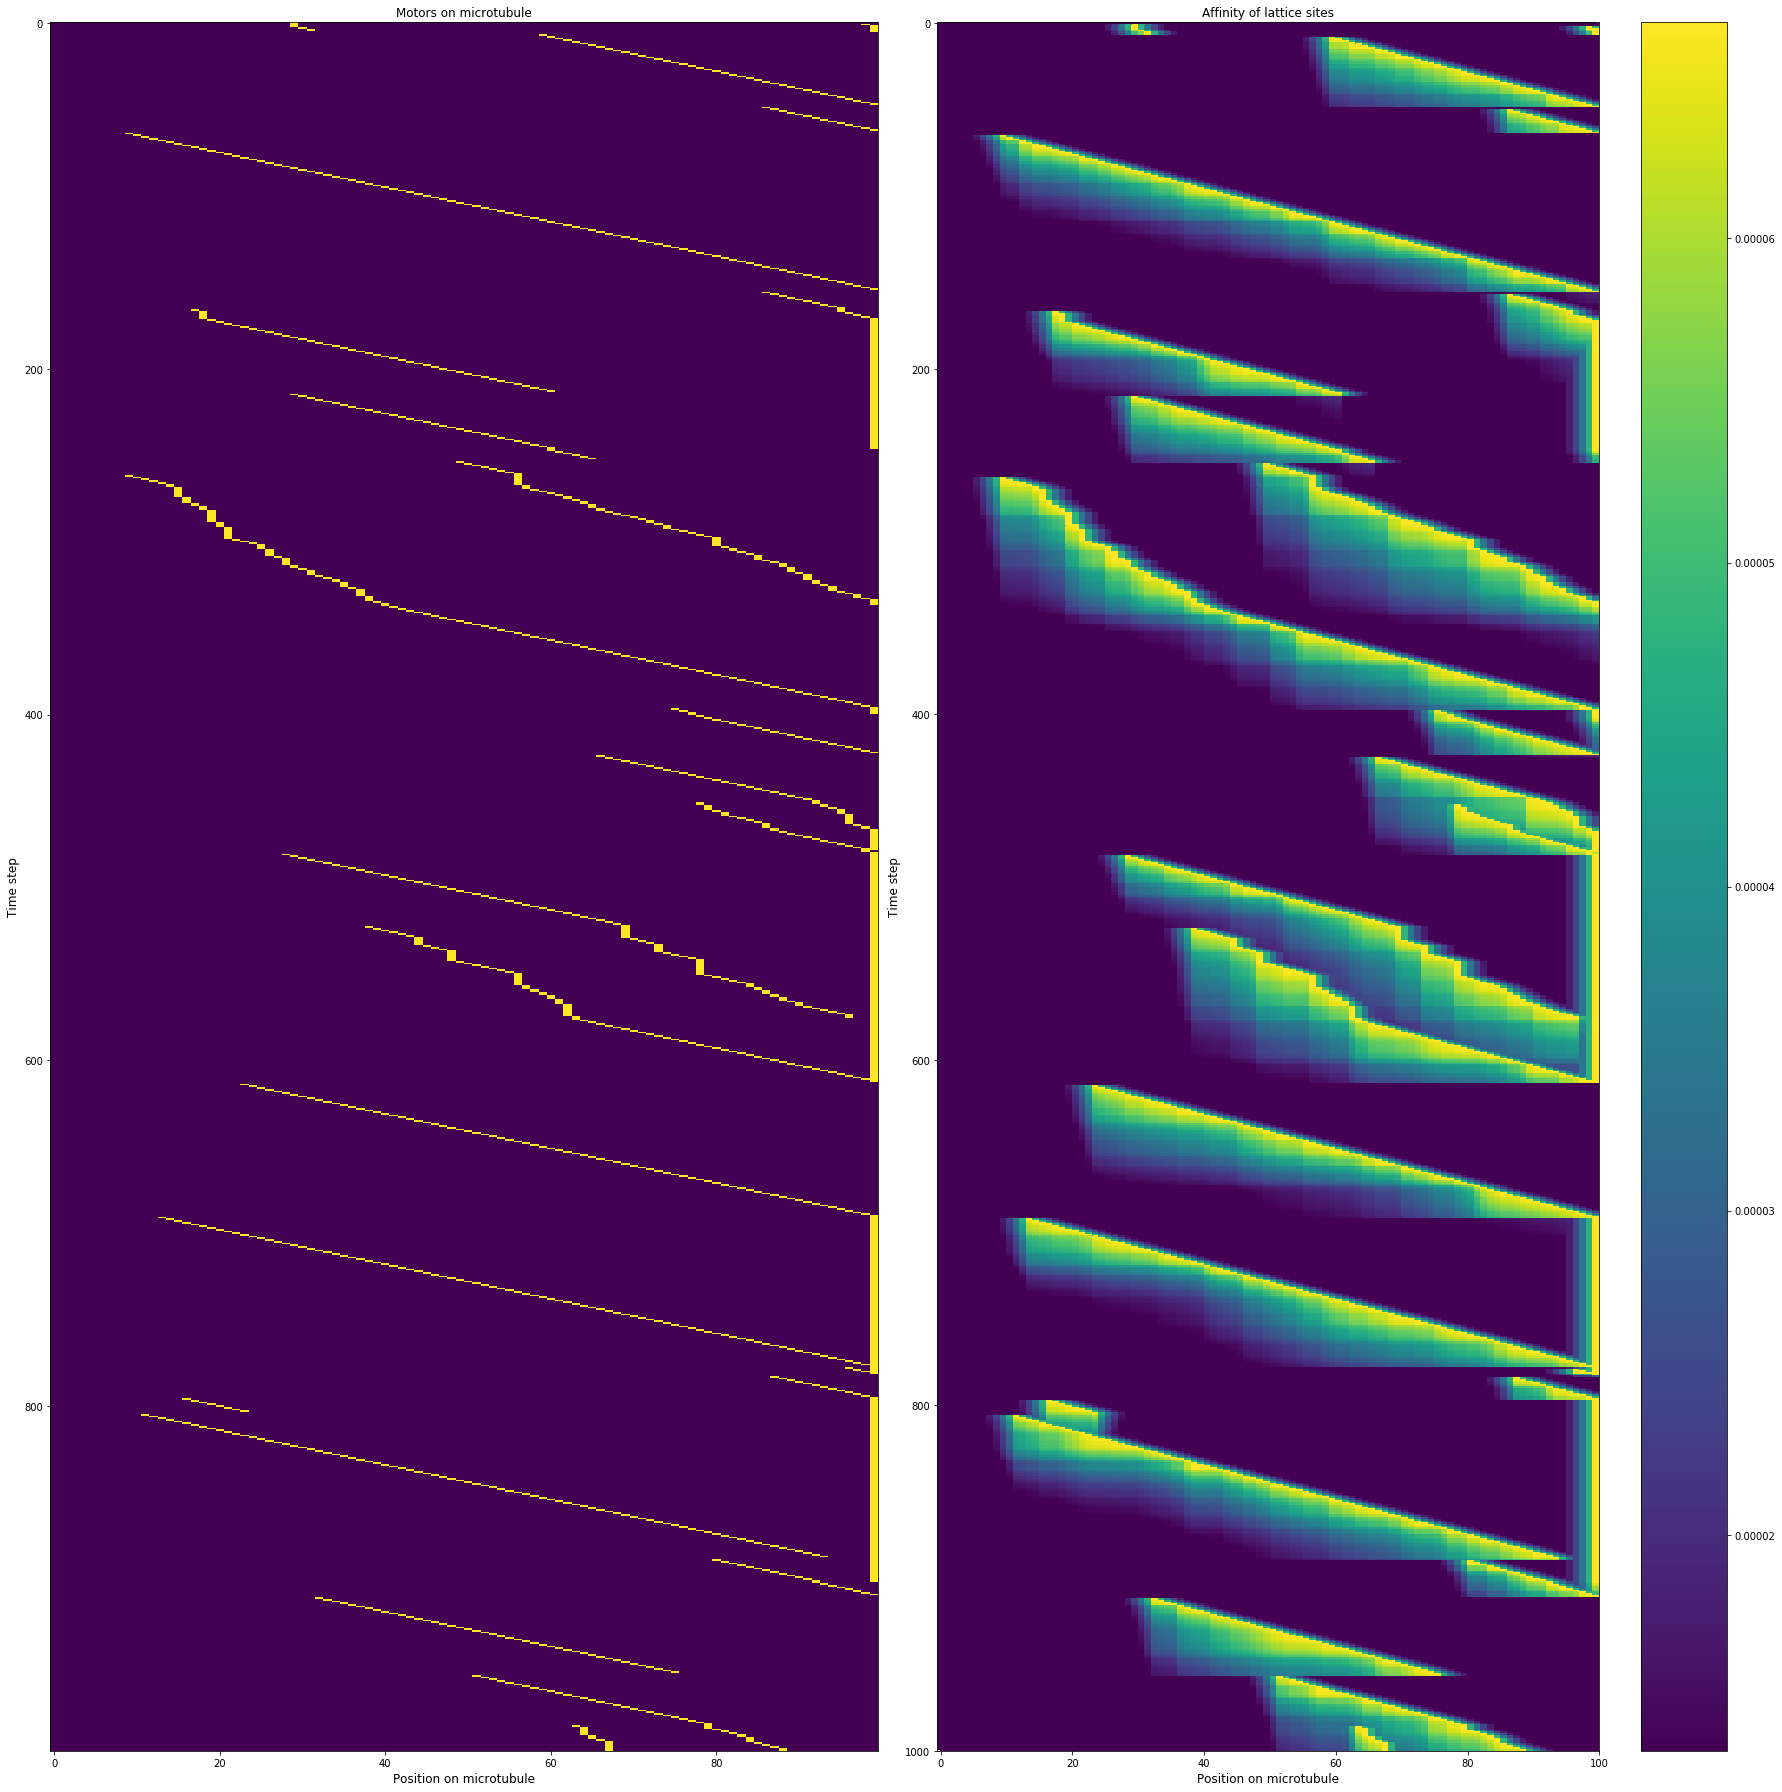

In [30]:
# plot results
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(25, 25)) #25x30 for 100 dimers, 10^3 steps; 25x3 for 1000 dimers, 10^3 steps; 25x100 for 1000 dimers, 10^5 steps
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

ax[0].imshow(mt, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)
#pcm = ax[1].pcolormesh(mt,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')

ax[1].imshow(affinity, cmap='viridis', aspect='auto', interpolation='nearest',clim=(color_lim[0],color_lim[1]))
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time step", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[1].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[1])

plt.tight_layout()

# save fig
if zsave == True:
    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_{}.png'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)
    plt.savefig(results_dir + file_name,dpi=130)

plt.show()

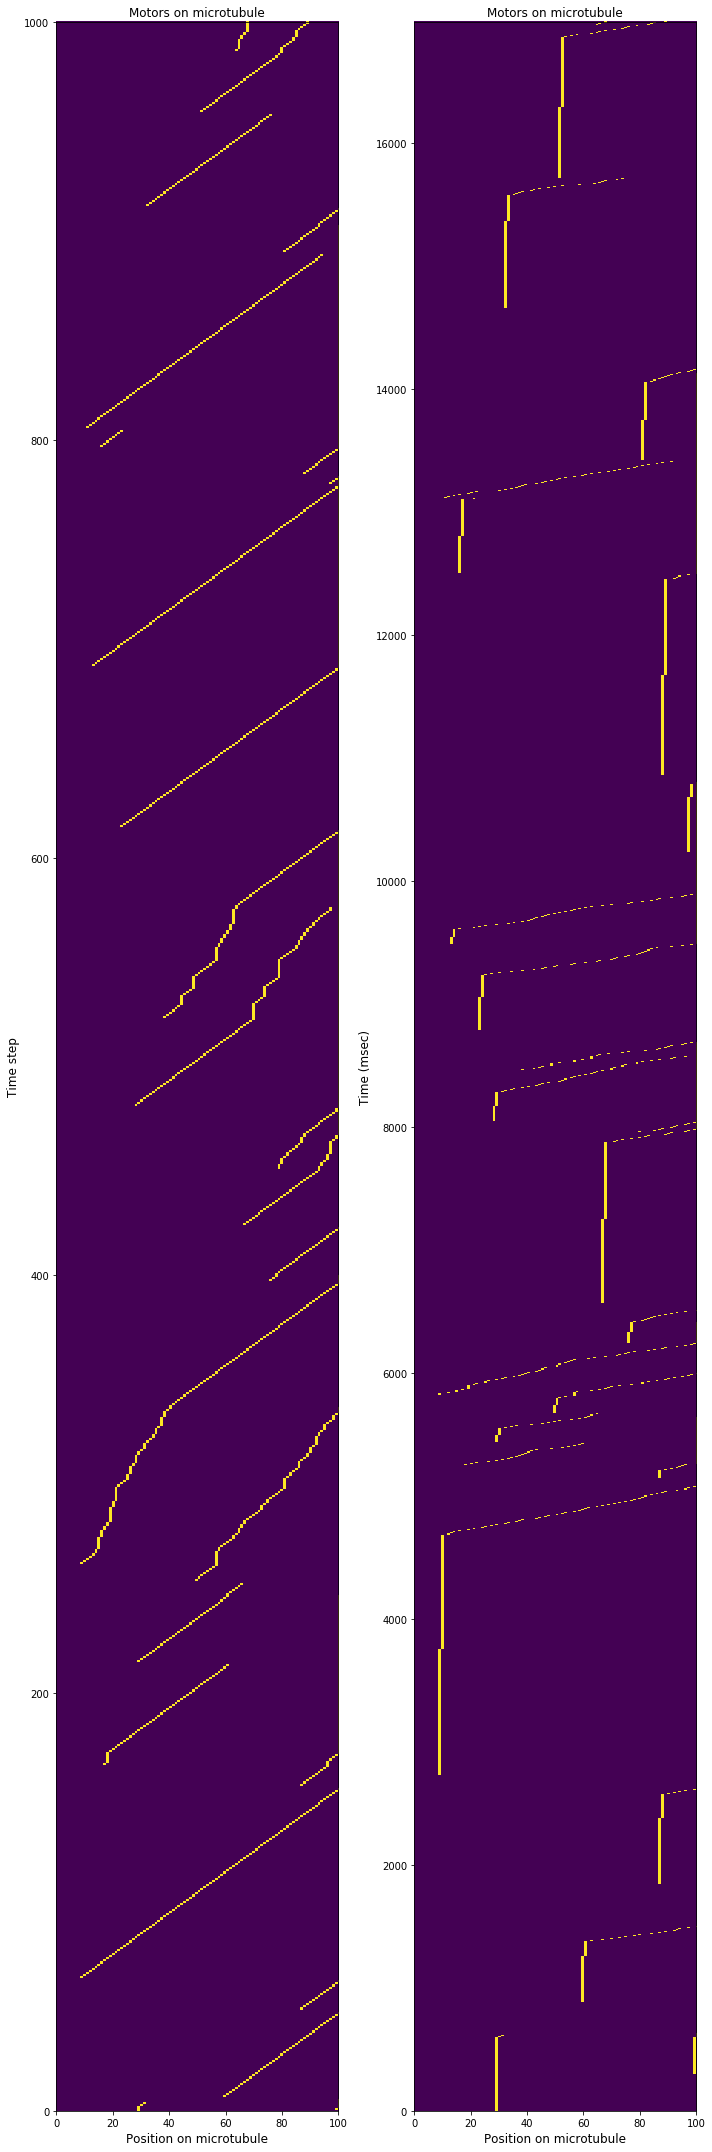

In [31]:
#plot kymographs with "real" time between frames
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 30))
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

x = np.linspace(0, mt_length, mt_length)
y = np.linspace(0, nstep, nstep)
y2 = t
z = mt

im = NonUniformImage(ax[0], interpolation='nearest', extent=(0, mt_length, 0, nstep), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y, z)
ax[0].images.append(im)
ax[0].set_xlim(0, mt_length)
ax[0].set_ylim(0, nstep)
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)

im = NonUniformImage(ax[1], interpolation='nearest', extent=(0, mt_length, 0, t[-1]), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y2, z)
ax[1].images.append(im)
ax[1].set_xlim(0, mt_length)
ax[1].set_ylim(0, t[-1])
ax[1].set_title("Motors on microtubule", fontsize=12)
ax[1].set_ylabel("Time (msec)", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)

plt.tight_layout()
plt.show()

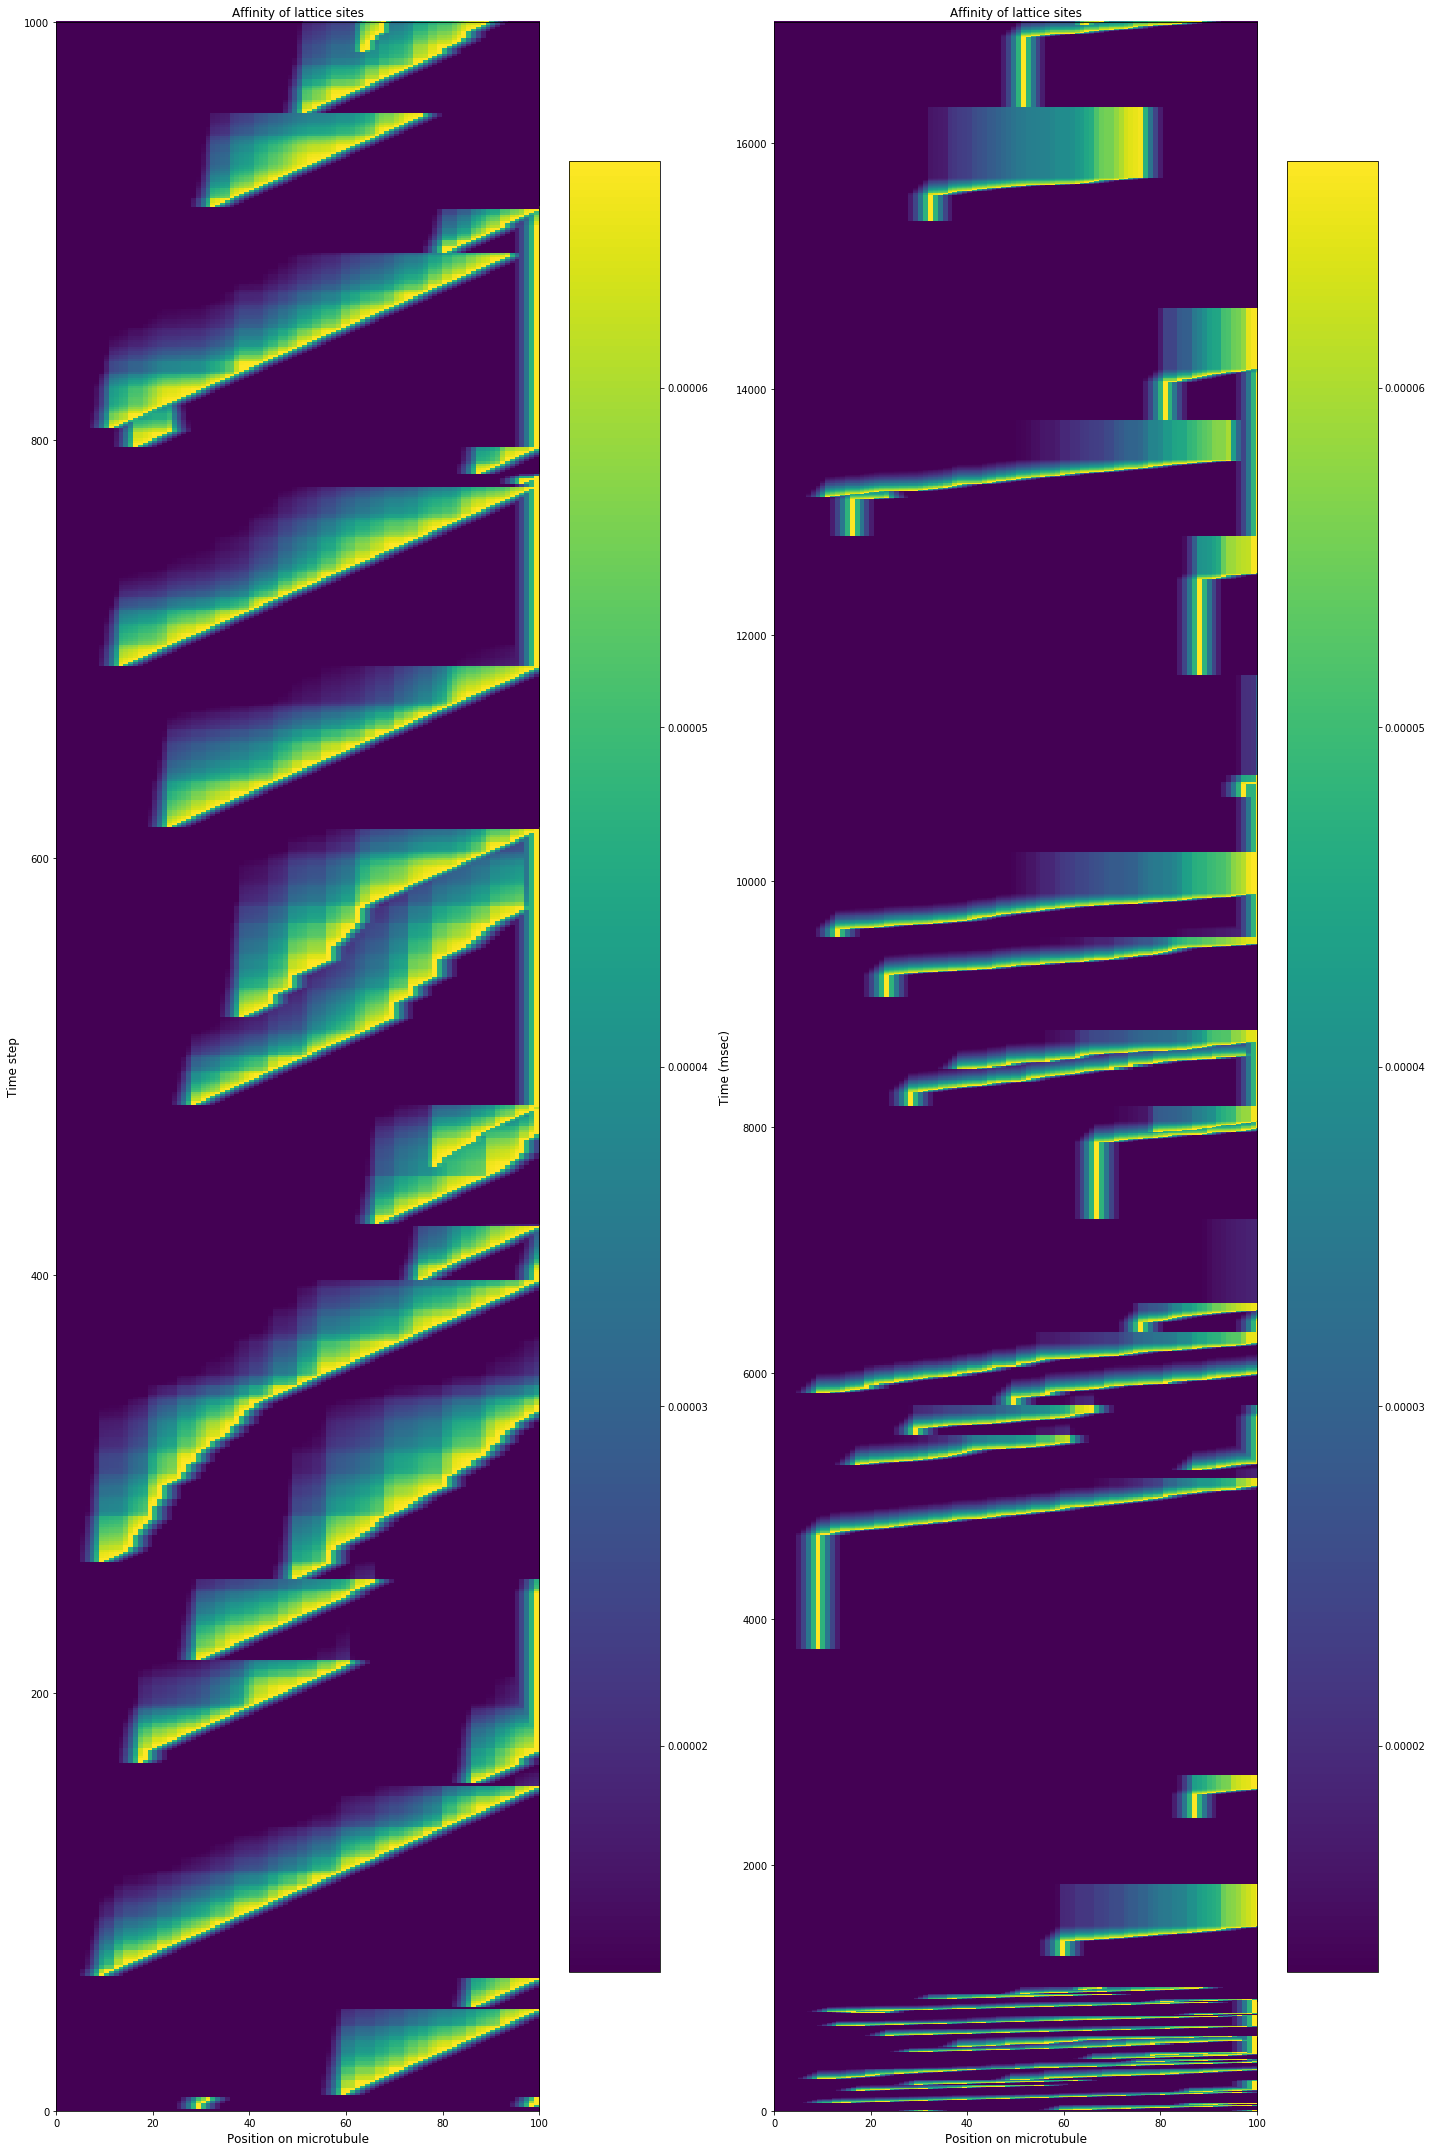

In [32]:
#plot affinity with "real" time between frames
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 30))
if zneg == False:
    color_lim = (k_on,alpha_max)
elif zneg == True:
    color_lim = (alpha_max,k_on)

x = np.linspace(0, mt_length, mt_length)
y = np.linspace(0, nstep, nstep)
y2 = t
z = affinity

im = NonUniformImage(ax[0], interpolation='nearest', extent=(0, mt_length, 0, nstep), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y, z)
ax[0].images.append(im)
ax[0].set_xlim(0, mt_length)
ax[0].set_ylim(0, nstep)
ax[0].set_title("Affinity of lattice sites", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[0].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[0])

im = NonUniformImage(ax[1], interpolation='nearest', extent=(0, mt_length, 0, t[-1]), origin = 'upper',cmap='viridis',clim=(color_lim[0],color_lim[1]))
im.set_data(x, y2, z)
ax[1].images.append(im)
ax[1].set_xlim(0, mt_length)
ax[1].set_ylim(0, t[-1])
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time (msec)", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)
pcm = ax[1].pcolormesh(affinity,norm = mpl.colors.Normalize(vmin=color_lim[0],vmax=color_lim[1]),cmap='viridis')
fig.colorbar(pcm, ax=ax[1])

plt.tight_layout()
plt.show()

In [23]:
#reformat to create an image from each time point
mt_as_stack = np.reshape(mt,(mt.shape[0],mt.shape[1],1))
mt_as_stack = np.moveaxis(mt_as_stack,1,-1) #t,y,x

padded_height = 7 #ideally an odd number
zero_row = np.zeros((1,mt.shape[1]),dtype=float)
mid_row = int(np.floor(padded_height/2))
padded_stack = np.zeros((mt.shape[0],padded_height,mt.shape[1]),dtype=float)

for i in range(mt.shape[0]):
    padded_stack[i,mid_row,:]=mt[i,]
    padded_stack[i,]=ndimage.gaussian_filter(padded_stack[i,], sigma=1)
    
padded_stack = padded_stack.astype(np.float64) / np.amax(padded_stack) # normalize the data to 0 - 1
padded_stack = 255 * padded_stack # scale by 255


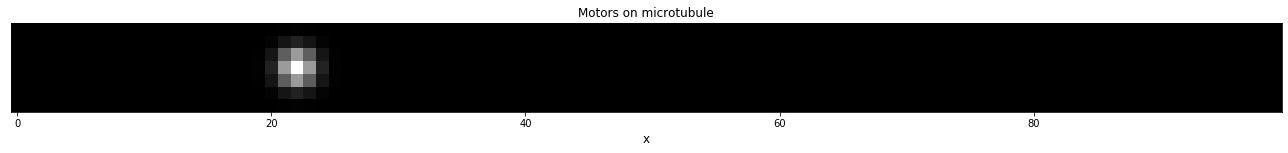

In [24]:
#check reformatting is working by plotting a random frame - if you don't see anything in the first frame, there may be no motors, so run it a couple times
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(18, 2))

ax.imshow(padded_stack[np.random.randint(0,nstep),], cmap='gray', interpolation='nearest')
ax.set_title("Motors on microtubule", fontsize=12)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("x", fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
#save a movie of the simulation
if zsave == True:
    fps = 100
    img_array = []

    script_dir = os.path.abspath('..') #os.path.dirname('..')
    results_dir = os.path.join(script_dir, 'Results/')
    file_name = 'Simulation_movie_{}.avi'.format(dt.datetime.now().strftime('%Y%m%d%H%M%S'))
    if not os.path.isdir(results_dir):    
        os.makedirs(results_dir)

    for i in range(mt.shape[0]):
        img = padded_stack[i,].astype(np.uint8)
        height, width = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(results_dir + file_name,cv2.VideoWriter_fourcc(*'M','J','P','G'), fps, size, False) #'DIVX'

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

### TO DO:
* Fix affinity decay with time
* Run simulation with time steps as above, but sample at 100ms frame rate
* Currently updating affinity for the future based on past time step
